**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

----


# Análisis Exploratorio y Curacion de datos

Grupo 15:
- Fassi, Carolina Noelia.
- Fassi, Angel Maximiliano.

---

# Trabajo práctico entregable - Parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [86]:
!pip uninstall decouple
!pip install python-decouple
!pip install SQLAlchemy

import matplotlib.pyplot as plt
import numpy
import pandas as pd
import seaborn
seaborn.set_context('talk')
import plotly
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings('ignore')
seaborn.set_context('talk')

from decouple import config
from sqlalchemy import create_engine, text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
import plotly
plotly.__version__
# Make sure it's 4.14.3

'5.5.0'

In [88]:
#conjunto de datos de Melbourne, Australia 
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:4]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,2.00,1.00,1.00,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00
1,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,4/02/2016,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
2,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
3,Abbotsford,40 Federation La,3,h,850000.00,PI,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,1.00,94.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00


In [89]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [90]:
#Convertir la columna Postcode a numerico para luego poder utilizarla como PK
melb_df['Postcode'] = pd.to_numeric(melb_df['Postcode'])

In [91]:
#conjunto de datos de AIRBNB
#data source: 'https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv'
interesting_cols = [
  'description', 'neighborhood_overview',
  'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
  'price', 'weekly_price', 'monthly_price',
  'latitude', 'longitude',
]
airbnb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',
    usecols=interesting_cols)
airbnb_df[:4]

,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105,-37.77,145.09,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057,-37.77,144.98,35,200.00,803.00
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182,-37.86,144.98,159,1253.00,4452.00
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071,-37.76,144.99,50,250.00,920.00


In [92]:
#Convertir la columna zipcode a numerico para luego poder utilizarla como PK
airbnb_df['zipcode'] = pd.to_numeric(airbnb_df.zipcode, errors='coerce')

In [93]:
relevant_cols = ['price', 'weekly_price', 'monthly_price', 'zipcode']

airbnb_price_by_zipcode = airbnb_df[relevant_cols].groupby('zipcode')\
  .agg({'price': ['mean', 'count'], 'weekly_price': 'mean',
        'monthly_price': 'mean'})\
  .reset_index()

airbnb_price_by_zipcode.columns = [
  ' '.join(col).strip()
  for col in airbnb_price_by_zipcode.columns.values]
# Rename columns
airbnb_price_by_zipcode = airbnb_price_by_zipcode.rename(
    columns={'price mean': 'airbnb_price_mean',
             'price count': 'airbnb_record_count',
             'weekly_price mean': 'airbnb_weekly_price_mean',
             'monthly_price mean': 'airbnb_monthly_price_mean'}
)

airbnb_price_by_zipcode[:]

,zipcode,airbnb_price_mean,airbnb_record_count,airbnb_weekly_price_mean,airbnb_monthly_price_mean
0,2010.00,40.00,1,NaN,NaN
1,2134.00,50.00,1,NaN,NaN
2,2582.00,104.00,1,NaN,NaN
3,3000.00,150.50,3367,918.74,3407.20
4,3001.00,132.50,2,NaN,NaN
...,...,...,...,...,...
242,7367.00,230.00,1,NaN,NaN
243,8938.00,296.00,1,NaN,NaN
244,9004.00,226.00,1,NaN,NaN
245,9540.00,245.00,1,NaN,NaN


In [94]:
airbnb_price_by_zipcode['zipcode'] = pd.to_numeric(airbnb_price_by_zipcode.zipcode, errors='coerce')

In [95]:
airbnb_price_by_zipcode.shape

(247, 5)

## Ejercicio 1 SQL: 

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.

4. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



In [96]:
#Creacion de la Base de Datos
DBMyA = create_engine('sqlite:///DBMyA.db', echo=True)
conn = DBMyA.connect()
#Ingestamos los datos de Melbourne 
melb_df.to_sql('MelbDB', con= DBMyA, if_exists='replace', index=False) 


2022-08-24 23:05:03,088 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("MelbDB")


2022-08-24 23:05:03,092 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,097 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("MelbDB")


2022-08-24 23:05:03,101 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,105 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2022-08-24 23:05:03,108 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,112 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("MelbDB")


2022-08-24 23:05:03,116 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,123 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:03,127 INFO sqlalchemy.engine.Engine [raw sql] ('MelbDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('MelbDB',)


2022-08-24 23:05:03,131 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.foreign_key_list("MelbDB")


2022-08-24 23:05:03,134 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,137 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.foreign_key_list("MelbDB")


2022-08-24 23:05:03,140 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,144 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:03,146 INFO sqlalchemy.engine.Engine [raw sql] ('MelbDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('MelbDB',)


2022-08-24 23:05:03,152 INFO sqlalchemy.engine.Engine PRAGMA main.index_list("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.index_list("MelbDB")


2022-08-24 23:05:03,155 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,158 INFO sqlalchemy.engine.Engine PRAGMA temp.index_list("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.index_list("MelbDB")


2022-08-24 23:05:03,161 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,164 INFO sqlalchemy.engine.Engine PRAGMA main.index_list("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.index_list("MelbDB")


2022-08-24 23:05:03,167 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,171 INFO sqlalchemy.engine.Engine PRAGMA temp.index_list("MelbDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.index_list("MelbDB")


2022-08-24 23:05:03,173 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:03,177 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:03,180 INFO sqlalchemy.engine.Engine [raw sql] ('MelbDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('MelbDB',)


2022-08-24 23:05:03,186 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:03,189 INFO sqlalchemy.engine.Engine 
DROP TABLE "MelbDB"


INFO:sqlalchemy.engine.Engine:
DROP TABLE "MelbDB"


2022-08-24 23:05:03,192 INFO sqlalchemy.engine.Engine [no key 0.00283s] ()


INFO:sqlalchemy.engine.Engine:[no key 0.00283s] ()


2022-08-24 23:05:03,243 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:03,251 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:03,257 INFO sqlalchemy.engine.Engine 
CREATE TABLE "MelbDB" (
	"Suburb" TEXT, 
	"Address" TEXT, 
	"Rooms" BIGINT, 
	"Type" TEXT, 
	"Price" FLOAT, 
	"Method" TEXT, 
	"SellerG" TEXT, 
	"Date" TEXT, 
	"Distance" FLOAT, 
	"Postcode" FLOAT, 
	"Bedroom2" FLOAT, 
	"Bathroom" FLOAT, 
	"Car" FLOAT, 
	"Landsize" FLOAT, 
	"BuildingArea" FLOAT, 
	"YearBuilt" FLOAT, 
	"CouncilArea" TEXT, 
	"Lattitude" FLOAT, 
	"Longtitude" FLOAT, 
	"Regionname" TEXT, 
	"Propertycount" FLOAT
)




INFO:sqlalchemy.engine.Engine:
CREATE TABLE "MelbDB" (
	"Suburb" TEXT, 
	"Address" TEXT, 
	"Rooms" BIGINT, 
	"Type" TEXT, 
	"Price" FLOAT, 
	"Method" TEXT, 
	"SellerG" TEXT, 
	"Date" TEXT, 
	"Distance" FLOAT, 
	"Postcode" FLOAT, 
	"Bedroom2" FLOAT, 
	"Bathroom" FLOAT, 
	"Car" FLOAT, 
	"Landsize" FLOAT, 
	"BuildingArea" FLOAT, 
	"YearBuilt" FLOAT, 
	"CouncilArea" TEXT, 
	"Lattitude" FLOAT, 
	"Longtitude" FLOAT, 
	"Regionname" TEXT, 
	"Propertycount" FLOAT
)




2022-08-24 23:05:03,260 INFO sqlalchemy.engine.Engine [no key 0.00312s] ()


INFO:sqlalchemy.engine.Engine:[no key 0.00312s] ()


2022-08-24 23:05:03,274 INFO sqlalchemy.engine.Engine COMMIT


ERROR:sqlalchemy.pool.impl.NullPool:Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/pool/base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/engine/default.py", line 682, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140171940083584 and this is thread id 140171515664128.
INFO:sqlalchemy.engine.Engine:COMMIT
ERROR:sqlalchemy.pool.impl.NullPool:Exception closing connection <sqlite3.Connection object at 0x7f7c2251ce30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "

2022-08-24 23:05:03,368 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:03,891 INFO sqlalchemy.engine.Engine INSERT INTO "MelbDB" ("Suburb", "Address", "Rooms", "Type", "Price", "Method", "SellerG", "Date", "Distance", "Postcode", "Bedroom2", "Bathroom", "Car", "Landsize", "BuildingArea", "YearBuilt", "CouncilArea", "Lattitude", "Longtitude", "Regionname", "Propertycount") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO:sqlalchemy.engine.Engine:INSERT INTO "MelbDB" ("Suburb", "Address", "Rooms", "Type", "Price", "Method", "SellerG", "Date", "Distance", "Postcode", "Bedroom2", "Bathroom", "Car", "Landsize", "BuildingArea", "YearBuilt", "CouncilArea", "Lattitude", "Longtitude", "Regionname", "Propertycount") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)


2022-08-24 23:05:03,898 INFO sqlalchemy.engine.Engine [generated in 0.47497s] (('Abbotsford', '85 Turner St', 2, 'h', 1480000.0, 'S', 'Biggin', '3/12/2016', 2.5, 3067.0, 2.0, 1.0, 1.0, 202.0, None, None, 'Yarra', -37.7996, 144.9984, 'Northern Metropolitan', 4019.0), ('Abbotsford', '25 Bloomburg St', 2, 'h', 1035000.0, 'S', 'Biggin', '4/02/2016', 2.5, 3067.0, 2.0, 1.0, 0.0, 156.0, 79.0, 1900.0, 'Yarra', -37.8079, 144.9934, 'Northern Metropolitan', 4019.0), ('Abbotsford', '5 Charles St', 3, 'h', 1465000.0, 'SP', 'Biggin', '4/03/2017', 2.5, 3067.0, 3.0, 2.0, 0.0, 134.0, 150.0, 1900.0, 'Yarra', -37.8093, 144.9944, 'Northern Metropolitan', 4019.0), ('Abbotsford', '40 Federation La', 3, 'h', 850000.0, 'PI', 'Biggin', '4/03/2017', 2.5, 3067.0, 3.0, 2.0, 1.0, 94.0, None, None, 'Yarra', -37.7969, 144.9969, 'Northern Metropolitan', 4019.0), ('Abbotsford', '55a Park St', 4, 'h', 1600000.0, 'VB', 'Nelson', '4/06/2016', 2.5, 3067.0, 3.0, 1.0, 2.0, 120.0, 142.0, 2014.0, 'Yarra', -37.8072, 144.9941, 

INFO:sqlalchemy.engine.Engine:[generated in 0.47497s] (('Abbotsford', '85 Turner St', 2, 'h', 1480000.0, 'S', 'Biggin', '3/12/2016', 2.5, 3067.0, 2.0, 1.0, 1.0, 202.0, None, None, 'Yarra', -37.7996, 144.9984, 'Northern Metropolitan', 4019.0), ('Abbotsford', '25 Bloomburg St', 2, 'h', 1035000.0, 'S', 'Biggin', '4/02/2016', 2.5, 3067.0, 2.0, 1.0, 0.0, 156.0, 79.0, 1900.0, 'Yarra', -37.8079, 144.9934, 'Northern Metropolitan', 4019.0), ('Abbotsford', '5 Charles St', 3, 'h', 1465000.0, 'SP', 'Biggin', '4/03/2017', 2.5, 3067.0, 3.0, 2.0, 0.0, 134.0, 150.0, 1900.0, 'Yarra', -37.8093, 144.9944, 'Northern Metropolitan', 4019.0), ('Abbotsford', '40 Federation La', 3, 'h', 850000.0, 'PI', 'Biggin', '4/03/2017', 2.5, 3067.0, 3.0, 2.0, 1.0, 94.0, None, None, 'Yarra', -37.7969, 144.9969, 'Northern Metropolitan', 4019.0), ('Abbotsford', '55a Park St', 4, 'h', 1600000.0, 'VB', 'Nelson', '4/06/2016', 2.5, 3067.0, 3.0, 1.0, 2.0, 120.0, 142.0, 2014.0, 'Yarra', -37.8072, 144.9941, 'Northern Metropolitan',

2022-08-24 23:05:03,999 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:04,023 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2022-08-24 23:05:04,030 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


In [97]:
#Ingestamos los Datos de AirBnB
airbnb_df.to_sql('ABDB', con = DBMyA, if_exists='replace', index=False) 

2022-08-24 23:05:04,072 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("ABDB")


2022-08-24 23:05:04,079 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,088 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("ABDB")


2022-08-24 23:05:04,091 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,099 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2022-08-24 23:05:04,103 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,113 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("ABDB")


2022-08-24 23:05:04,118 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,125 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:04,130 INFO sqlalchemy.engine.Engine [raw sql] ('ABDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('ABDB',)


2022-08-24 23:05:04,133 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.foreign_key_list("ABDB")


2022-08-24 23:05:04,139 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,142 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.foreign_key_list("ABDB")


2022-08-24 23:05:04,145 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,149 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:04,152 INFO sqlalchemy.engine.Engine [raw sql] ('ABDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('ABDB',)


2022-08-24 23:05:04,155 INFO sqlalchemy.engine.Engine PRAGMA main.index_list("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.index_list("ABDB")


2022-08-24 23:05:04,158 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,161 INFO sqlalchemy.engine.Engine PRAGMA temp.index_list("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.index_list("ABDB")


2022-08-24 23:05:04,164 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,167 INFO sqlalchemy.engine.Engine PRAGMA main.index_list("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.index_list("ABDB")


2022-08-24 23:05:04,170 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,173 INFO sqlalchemy.engine.Engine PRAGMA temp.index_list("ABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.index_list("ABDB")


2022-08-24 23:05:04,176 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:04,179 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:04,182 INFO sqlalchemy.engine.Engine [raw sql] ('ABDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('ABDB',)


2022-08-24 23:05:04,186 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:04,189 INFO sqlalchemy.engine.Engine 
DROP TABLE "ABDB"


INFO:sqlalchemy.engine.Engine:
DROP TABLE "ABDB"


2022-08-24 23:05:04,192 INFO sqlalchemy.engine.Engine [no key 0.00304s] ()


INFO:sqlalchemy.engine.Engine:[no key 0.00304s] ()


2022-08-24 23:05:04,643 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:04,654 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:04,664 INFO sqlalchemy.engine.Engine 
CREATE TABLE "ABDB" (
	description TEXT, 
	neighborhood_overview TEXT, 
	street TEXT, 
	neighborhood TEXT, 
	city TEXT, 
	suburb TEXT, 
	state TEXT, 
	zipcode FLOAT, 
	latitude FLOAT, 
	longitude FLOAT, 
	price BIGINT, 
	weekly_price FLOAT, 
	monthly_price FLOAT
)




INFO:sqlalchemy.engine.Engine:
CREATE TABLE "ABDB" (
	description TEXT, 
	neighborhood_overview TEXT, 
	street TEXT, 
	neighborhood TEXT, 
	city TEXT, 
	suburb TEXT, 
	state TEXT, 
	zipcode FLOAT, 
	latitude FLOAT, 
	longitude FLOAT, 
	price BIGINT, 
	weekly_price FLOAT, 
	monthly_price FLOAT
)




2022-08-24 23:05:04,668 INFO sqlalchemy.engine.Engine [no key 0.00405s] ()


INFO:sqlalchemy.engine.Engine:[no key 0.00405s] ()


2022-08-24 23:05:04,680 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:04,724 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:05,299 INFO sqlalchemy.engine.Engine INSERT INTO "ABDB" (description, neighborhood_overview, street, neighborhood, city, suburb, state, zipcode, latitude, longitude, price, weekly_price, monthly_price) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)


INFO:sqlalchemy.engine.Engine:INSERT INTO "ABDB" (description, neighborhood_overview, street, neighborhood, city, suburb, state, zipcode, latitude, longitude, price, weekly_price, monthly_price) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)


2022-08-24 23:05:05,307 INFO sqlalchemy.engine.Engine [generated in 0.52904s] (('House: Clean, New, Modern, Quite, Safe. 10Km from the City. Golf course, Tennis courts, bus stop & shops walking distance!! Rooms: Contains one queen ... (702 characters truncated) ... pproximately what your daily in and out hours might look like.  Note: There is a 5 year old fun loving dog who lives with us and is part of our famil', 'Very safe! Family oriented. Older age group.', 'Bulleen, VIC, Australia', 'Balwyn North', 'Manningham', 'Bulleen', 'VIC', 3105.0, -37.77268393, 145.0921328, 60, None, None), ("A large air conditioned room with queen spring mattress bed in a vintage apartment. Located right outside is a tram to the city just 19 minutes away. ... (702 characters truncated) ... ou east to Bundoora and west to Pacoevale. The Lygon Street tram line that goes past Melbourne University is 10 minutes walk west and Sydney Road and", "This hip area is a crossroads between two great cultural strips of 

INFO:sqlalchemy.engine.Engine:[generated in 0.52904s] (('House: Clean, New, Modern, Quite, Safe. 10Km from the City. Golf course, Tennis courts, bus stop & shops walking distance!! Rooms: Contains one queen ... (702 characters truncated) ... pproximately what your daily in and out hours might look like.  Note: There is a 5 year old fun loving dog who lives with us and is part of our famil', 'Very safe! Family oriented. Older age group.', 'Bulleen, VIC, Australia', 'Balwyn North', 'Manningham', 'Bulleen', 'VIC', 3105.0, -37.77268393, 145.0921328, 60, None, None), ("A large air conditioned room with queen spring mattress bed in a vintage apartment. Located right outside is a tram to the city just 19 minutes away. ... (702 characters truncated) ... ou east to Bundoora and west to Pacoevale. The Lygon Street tram line that goes past Melbourne University is 10 minutes walk west and Sydney Road and", "This hip area is a crossroads between two great cultural strips of inner Northern Melbourne

2022-08-24 23:05:05,519 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:05,601 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2022-08-24 23:05:05,612 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


In [98]:
airbnb_price_by_zipcode.to_sql('zABDB', con = DBMyA, if_exists='replace', index=False)

2022-08-24 23:05:05,636 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("zABDB")


2022-08-24 23:05:05,640 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,644 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("zABDB")


2022-08-24 23:05:05,646 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,650 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2022-08-24 23:05:05,653 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,657 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.table_info("zABDB")


2022-08-24 23:05:05,660 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,670 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:05,673 INFO sqlalchemy.engine.Engine [raw sql] ('zABDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('zABDB',)


2022-08-24 23:05:05,676 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.foreign_key_list("zABDB")


2022-08-24 23:05:05,679 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,682 INFO sqlalchemy.engine.Engine PRAGMA temp.foreign_key_list("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.foreign_key_list("zABDB")


2022-08-24 23:05:05,685 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,688 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:05,691 INFO sqlalchemy.engine.Engine [raw sql] ('zABDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('zABDB',)


2022-08-24 23:05:05,694 INFO sqlalchemy.engine.Engine PRAGMA main.index_list("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.index_list("zABDB")


2022-08-24 23:05:05,697 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,699 INFO sqlalchemy.engine.Engine PRAGMA temp.index_list("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.index_list("zABDB")


2022-08-24 23:05:05,702 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,705 INFO sqlalchemy.engine.Engine PRAGMA main.index_list("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA main.index_list("zABDB")


2022-08-24 23:05:05,708 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,711 INFO sqlalchemy.engine.Engine PRAGMA temp.index_list("zABDB")


INFO:sqlalchemy.engine.Engine:PRAGMA temp.index_list("zABDB")


2022-08-24 23:05:05,714 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


2022-08-24 23:05:05,719 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


INFO:sqlalchemy.engine.Engine:SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'


2022-08-24 23:05:05,722 INFO sqlalchemy.engine.Engine [raw sql] ('zABDB',)


INFO:sqlalchemy.engine.Engine:[raw sql] ('zABDB',)


2022-08-24 23:05:05,725 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:05,730 INFO sqlalchemy.engine.Engine 
DROP TABLE "zABDB"


INFO:sqlalchemy.engine.Engine:
DROP TABLE "zABDB"


2022-08-24 23:05:05,733 INFO sqlalchemy.engine.Engine [no key 0.00276s] ()


INFO:sqlalchemy.engine.Engine:[no key 0.00276s] ()


2022-08-24 23:05:05,744 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:05,749 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:05,752 INFO sqlalchemy.engine.Engine 
CREATE TABLE "zABDB" (
	zipcode FLOAT, 
	airbnb_price_mean FLOAT, 
	airbnb_record_count BIGINT, 
	airbnb_weekly_price_mean FLOAT, 
	airbnb_monthly_price_mean FLOAT
)




INFO:sqlalchemy.engine.Engine:
CREATE TABLE "zABDB" (
	zipcode FLOAT, 
	airbnb_price_mean FLOAT, 
	airbnb_record_count BIGINT, 
	airbnb_weekly_price_mean FLOAT, 
	airbnb_monthly_price_mean FLOAT
)




2022-08-24 23:05:05,755 INFO sqlalchemy.engine.Engine [no key 0.00278s] ()


INFO:sqlalchemy.engine.Engine:[no key 0.00278s] ()


2022-08-24 23:05:05,766 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:05,770 INFO sqlalchemy.engine.Engine BEGIN (implicit)


INFO:sqlalchemy.engine.Engine:BEGIN (implicit)


2022-08-24 23:05:05,779 INFO sqlalchemy.engine.Engine INSERT INTO "zABDB" (zipcode, airbnb_price_mean, airbnb_record_count, airbnb_weekly_price_mean, airbnb_monthly_price_mean) VALUES (?, ?, ?, ?, ?)


INFO:sqlalchemy.engine.Engine:INSERT INTO "zABDB" (zipcode, airbnb_price_mean, airbnb_record_count, airbnb_weekly_price_mean, airbnb_monthly_price_mean) VALUES (?, ?, ?, ?, ?)


2022-08-24 23:05:05,782 INFO sqlalchemy.engine.Engine [generated in 0.00777s] ((2010.0, 40.0, 1, None, None), (2134.0, 50.0, 1, None, None), (2582.0, 104.0, 1, None, None), (3000.0, 150.5043065043065, 3367, 918.7389558232932, 3407.204651162791), (3001.0, 132.5, 2, None, None), (3002.0, 200.9796954314721, 197, 956.3793103448276, 3712.714285714286), (3003.0, 130.20599250936328, 267, 760.2, 2629.5), (3004.0, 158.27197802197801, 728, 1061.1714285714286, 3759.925925925926)  ... displaying 10 of 247 total bound parameter sets ...  (9540.0, 245.0, 1, None, None), (30122.0, 75.0, 1, 525.0, 2281.0))


INFO:sqlalchemy.engine.Engine:[generated in 0.00777s] ((2010.0, 40.0, 1, None, None), (2134.0, 50.0, 1, None, None), (2582.0, 104.0, 1, None, None), (3000.0, 150.5043065043065, 3367, 918.7389558232932, 3407.204651162791), (3001.0, 132.5, 2, None, None), (3002.0, 200.9796954314721, 197, 956.3793103448276, 3712.714285714286), (3003.0, 130.20599250936328, 267, 760.2, 2629.5), (3004.0, 158.27197802197801, 728, 1061.1714285714286, 3759.925925925926)  ... displaying 10 of 247 total bound parameter sets ...  (9540.0, 245.0, 1, None, None), (30122.0, 75.0, 1, 525.0, 2281.0))


2022-08-24 23:05:05,787 INFO sqlalchemy.engine.Engine COMMIT


INFO:sqlalchemy.engine.Engine:COMMIT


2022-08-24 23:05:05,799 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


INFO:sqlalchemy.engine.Engine:SELECT name FROM sqlite_master WHERE type='table' ORDER BY name


2022-08-24 23:05:05,801 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


**Consultas:**
* cantidad de registros totales por ciudad.
* cantidad de registros totales por barrio y ciudad




In [99]:
pd.read_sql_query('SELECT * FROM MelbDB', DBMyA)

2022-08-24 23:05:05,813 INFO sqlalchemy.engine.Engine SELECT * FROM MelbDB


INFO:sqlalchemy.engine.Engine:SELECT * FROM MelbDB


2022-08-24 23:05:05,816 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,2.00,1.00,1.00,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00
1,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,4/02/2016,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
2,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
3,Abbotsford,40 Federation La,3,h,850000.00,PI,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,1.00,94.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00
4,Abbotsford,55a Park St,4,h,1600000.00,VB,Nelson,4/06/2016,2.50,3067.00,3.00,1.00,2.00,120.00,142.00,2014.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.00,S,Barry,26/08/2017,16.70,3150.00,4.00,2.00,2.00,652.00,NaN,1981.00,None,-37.91,145.17,South-Eastern Metropolitan,7392.00
13576,Williamstown,77 Merrett Dr,3,h,1031000.00,SP,Williams,26/08/2017,6.80,3016.00,3.00,2.00,2.00,333.00,133.00,1995.00,None,-37.86,144.88,Western Metropolitan,6380.00
13577,Williamstown,83 Power St,3,h,1170000.00,S,Raine,26/08/2017,6.80,3016.00,3.00,2.00,4.00,436.00,NaN,1997.00,None,-37.85,144.89,Western Metropolitan,6380.00
13578,Williamstown,96 Verdon St,4,h,2500000.00,PI,Sweeney,26/08/2017,6.80,3016.00,4.00,1.00,5.00,866.00,157.00,1920.00,None,-37.86,144.89,Western Metropolitan,6380.00


In [100]:
pd.read_sql_query('SELECT * FROM ABDB', DBMyA)

2022-08-24 23:05:06,242 INFO sqlalchemy.engine.Engine SELECT * FROM ABDB


INFO:sqlalchemy.engine.Engine:SELECT * FROM ABDB


2022-08-24 23:05:06,250 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


,description,neighborhood_overview,street,neighborhood,city,suburb,state,zipcode,latitude,longitude,price,weekly_price,monthly_price
0,"House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,"Bulleen, VIC, Australia",Balwyn North,Manningham,Bulleen,VIC,3105.00,-37.77,145.09,60,NaN,NaN
1,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,"Brunswick East, VIC, Australia",Brunswick,Moreland,Brunswick East,VIC,3057.00,-37.77,144.98,35,200.00,803.00
2,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,"St Kilda, VIC, Australia",St Kilda,Port Phillip,St Kilda,VIC,3182.00,-37.86,144.98,159,1253.00,4452.00
3,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...","Thornbury, VIC, Australia",Thornbury,Darebin,Thornbury,VIC,3071.00,-37.76,144.99,50,250.00,920.00
4,We offer comfortable accommodation in Inner Me...,None,"St Kilda East, VIC, Australia",St Kilda East,Port Phillip,St Kilda East,VIC,3183.00,-37.86,144.99,69,400.00,1900.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22890,"near city, near tram station",None,"Carlton, VIC, Australia",Carlton,Melbourne,Carlton,VIC,3053.00,-37.80,144.96,55,NaN,NaN
22891,"Close to: Melton Rail, Coles, Coffee Lounge an...",None,"Melton South, VIC, Australia",None,Melton,Melton South,VIC,3338.00,-37.71,144.57,129,NaN,NaN
22892,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",None,"Glen Waverley, VIC, Australia",None,Monash,Glen Waverley,VIC,3150.00,-37.88,145.16,53,NaN,NaN
22893,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,"Southbank, VIC, Australia",Southbank,Melbourne,Southbank,VIC,3006.00,-37.83,144.95,130,NaN,NaN


In [101]:
#Cantidad de registros por ciudad en la base de AirBnB
pd.read_sql_query('SELECT city, COUNT(*) FROM ABDB GROUP BY city', DBMyA)

2022-08-24 23:05:06,487 INFO sqlalchemy.engine.Engine SELECT city, COUNT(*) FROM ABDB GROUP BY city


INFO:sqlalchemy.engine.Engine:SELECT city, COUNT(*) FROM ABDB GROUP BY city


2022-08-24 23:05:06,494 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


,city,COUNT(*)
0,Banyule,203
1,Bayside,375
2,Boroondara,664
3,Brimbank,108
4,Cardinia,123
5,Casey,153
6,Darebin,698
7,Frankston,177
8,Glen Eira,631
9,Greater Dandenong,147


In [102]:
#Cantidad de resgistros por ciudad y por barrio 
pd.read_sql_query('SELECT city, neighborhood, COUNT(*) FROM ABDB GROUP BY city,neighborhood', DBMyA)

2022-08-24 23:05:06,541 INFO sqlalchemy.engine.Engine SELECT city, neighborhood, COUNT(*) FROM ABDB GROUP BY city,neighborhood


INFO:sqlalchemy.engine.Engine:SELECT city, neighborhood, COUNT(*) FROM ABDB GROUP BY city,neighborhood


2022-08-24 23:05:06,547 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


,city,neighborhood,COUNT(*)
0,Banyule,None,174
1,Banyule,Alphington,16
2,Banyule,Preston,8
3,Banyule,Thornbury,5
4,Bayside,None,170
...,...,...,...
129,Yarra,Fitzroy,381
130,Yarra,Fitzroy North,225
131,Yarra,Northcote,6
132,Yarra,Richmond,547


In [103]:
# Rango de valores que toman los codigos postales de Melbourne.
pd.read_sql_query('SELECT postcode FROM MelbDB GROUP BY postcode', DBMyA)


2022-08-24 23:05:06,603 INFO sqlalchemy.engine.Engine SELECT postcode FROM MelbDB GROUP BY postcode


INFO:sqlalchemy.engine.Engine:SELECT postcode FROM MelbDB GROUP BY postcode


2022-08-24 23:05:06,612 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


,Postcode
0,3000.00
1,3002.00
2,3003.00
3,3006.00
4,3008.00
...,...
193,3809.00
194,3810.00
195,3910.00
196,3976.00


Los Codigos postales de la ciudad de Melbourne se encuentran entre los 3000 y 4000.

In [104]:
#Entre el intervalo de Codigos postales de Melbourne planteado, cuantos registros hay.
pd.read_sql_query('SELECT Zipcode, COUNT(*) FROM ABDB WHERE Zipcode BETWEEN 3000 AND 4000 GROUP BY Zipcode', DBMyA)

2022-08-24 23:05:06,654 INFO sqlalchemy.engine.Engine SELECT Zipcode, COUNT(*) FROM ABDB WHERE Zipcode BETWEEN 3000 AND 4000 GROUP BY Zipcode


INFO:sqlalchemy.engine.Engine:SELECT Zipcode, COUNT(*) FROM ABDB WHERE Zipcode BETWEEN 3000 AND 4000 GROUP BY Zipcode


2022-08-24 23:05:06,658 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


,zipcode,COUNT(*)
0,3000.00,3367
1,3001.00,2
2,3002.00,197
3,3003.00,267
4,3004.00,728
...,...,...
229,3976.00,2
230,3977.00,45
231,3978.00,7
232,3980.00,5


In [105]:
Union=pd.read_sql_query('SELECT * FROM MelbDB M LEFT JOIN zABDB Z ON M.Postcode = Z.zipcode', DBMyA)


2022-08-24 23:05:06,716 INFO sqlalchemy.engine.Engine SELECT * FROM MelbDB M LEFT JOIN zABDB Z ON M.Postcode = Z.zipcode


INFO:sqlalchemy.engine.Engine:SELECT * FROM MelbDB M LEFT JOIN zABDB Z ON M.Postcode = Z.zipcode


2022-08-24 23:05:06,722 INFO sqlalchemy.engine.Engine [raw sql] ()


INFO:sqlalchemy.engine.Engine:[raw sql] ()


In [106]:
Union [:4]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,zipcode,airbnb_price_mean,airbnb_record_count,airbnb_weekly_price_mean,airbnb_monthly_price_mean
0,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,2.00,1.00,1.00,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,3067.00,130.62,258.00,605.15,2187.03
1,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,4/02/2016,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00,3067.00,130.62,258.00,605.15,2187.03
2,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00,3067.00,130.62,258.00,605.15,2187.03
3,Abbotsford,40 Federation La,3,h,850000.00,PI,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,1.00,94.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,3067.00,130.62,258.00,605.15,2187.03


In [107]:
Union.columns


Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount', 'zipcode',
       'airbnb_price_mean', 'airbnb_record_count', 'airbnb_weekly_price_mean',
       'airbnb_monthly_price_mean'],
      dtype='object')



---



## Ejercicio 2: 

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar las columnas seleccionadas y las que no lo fueron.
 - Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.

2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico. 
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana o el mínimo.
  1. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  2. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.



---



In [108]:
melb_df.columns

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [109]:
#creamos una copia del df para no afectar el original
melb1_df=melb_df.copy()

A continuacion, se analiza la distribucion de las variables para detectar posibles outliers, y tambien se analiza si presentan problemas potenciales.

In [110]:
melb1_df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.00,13580.00,13580.00,13580.00,13580.00,13580.00,13518.00,13580.00,7130.00,8205.00,13580.00,13580.00,13580.00
mean,2.94,1075684.08,10.14,3105.30,2.91,1.53,1.61,558.42,151.97,1964.68,-37.81,145.00,7454.42
std,0.96,639310.72,5.87,90.68,0.97,0.69,0.96,3990.67,541.01,37.27,0.08,0.10,4378.58
min,1.00,85000.00,0.00,3000.00,0.00,0.00,0.00,0.00,0.00,1196.00,-38.18,144.43,249.00
25%,2.00,650000.00,6.10,3044.00,2.00,1.00,1.00,177.00,93.00,1940.00,-37.86,144.93,4380.00
50%,3.00,903000.00,9.20,3084.00,3.00,1.00,2.00,440.00,126.00,1970.00,-37.80,145.00,6555.00
75%,3.00,1330000.00,13.00,3148.00,3.00,2.00,2.00,651.00,174.00,1999.00,-37.76,145.06,10331.00
max,10.00,9000000.00,48.10,3977.00,20.00,8.00,10.00,433014.00,44515.00,2018.00,-37.41,145.53,21650.00


In [111]:
missing_values_count = melb1_df.isna().sum() #cuales son los NaN
missing_values_count

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [112]:
melb1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

**Price**: Se visualiza que la mayoria de los valores estan acumulados hasta los 2.000.000, y hay pocos valores altos. Por lo tanto, se podria recortar los valores hasta el 95% para no perder tanta informacion, con ese limite se perderian aprox 670 registros.

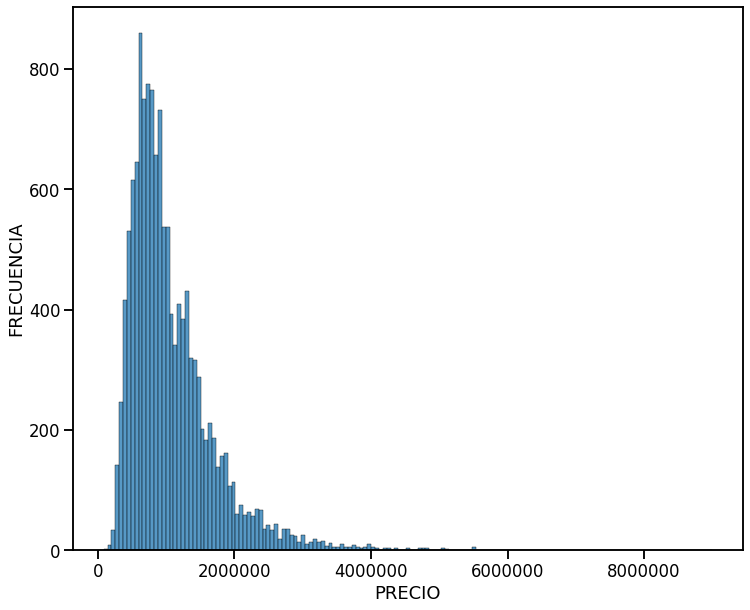

In [113]:
pd.options.display.float_format = '{:.2f}'.format

fig = plt.figure(figsize=(12,10))
seaborn.histplot(x=melb1_df["Price"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("PRECIO")
plt.ylabel("FRECUENCIA")
plt.show()

In [114]:
max=melb1_df["Price"].quantile(.95)
melb2_df= melb1_df[((melb1_df['Price']<(max)))]

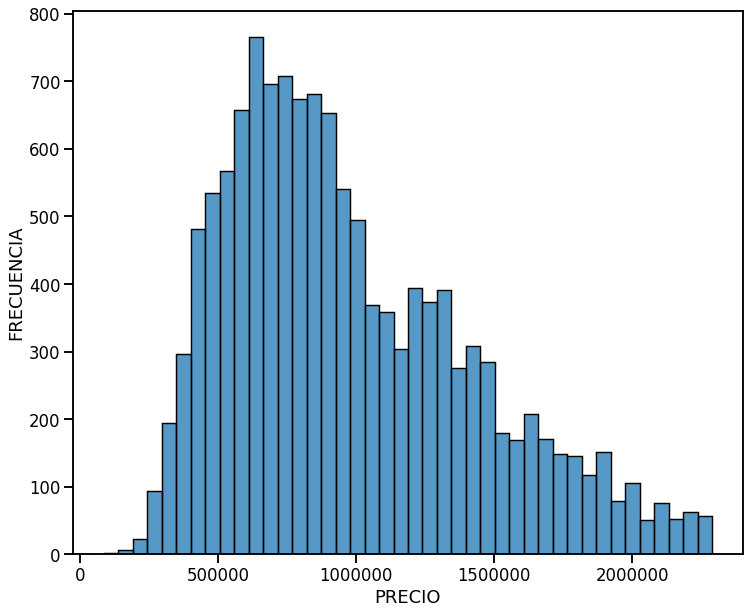

In [115]:
fig = plt.figure(figsize=(12,10))
seaborn.histplot(x=melb2_df["Price"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("PRECIO")
plt.ylabel("FRECUENCIA")
plt.show()

In [116]:
melb3_df=melb2_df.copy()

**Rooms**: Se puede ver que la mayoria de las propiedades tienen entre 2 y 4 habitaciones, y no hay valores ceros.

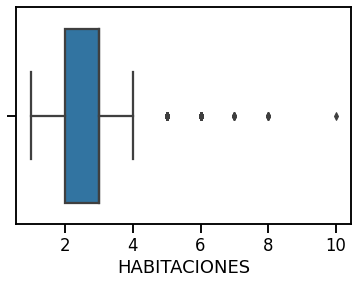

In [117]:
seaborn.boxplot(x=melb3_df["Rooms"])
plt.xlabel("HABITACIONES")
plt.show()

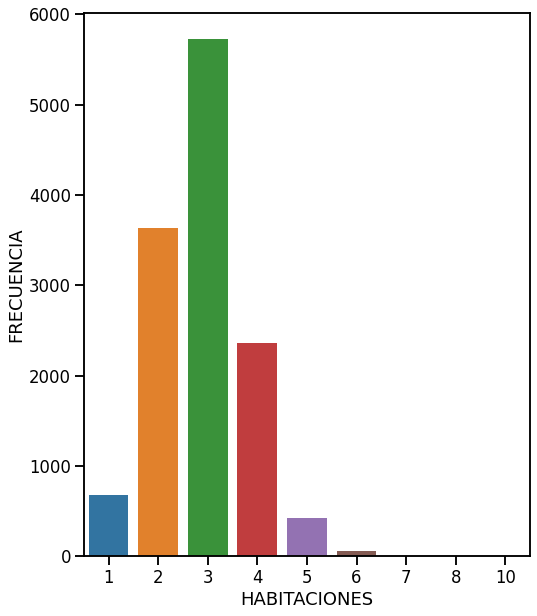

In [118]:
fig = plt.figure(figsize=(8,10))
seaborn.countplot(melb3_df.Rooms)
plt.xticks(rotation=0)
plt.xlabel("HABITACIONES")
plt.ylabel("FRECUENCIA")
plt.show()

**Bedroom2**: Esta variable tiene una alta correlacion con la variable "Rooms", 0.94, por lo tanto, se podria optar por solo dejar una de ambas.
Bedroom2 tiene un outlier de 20, y el resto de los valores graficamente parecen aportar las mismas caracteristicas que Room.
Finalmente, descartamos Bedroom2.

In [119]:
dfs=melb3_df[['Bedroom2', 'Rooms']]
dfs.corr()

,Bedroom2,Rooms
Bedroom2,1.00,0.94
Rooms,0.94,1.00


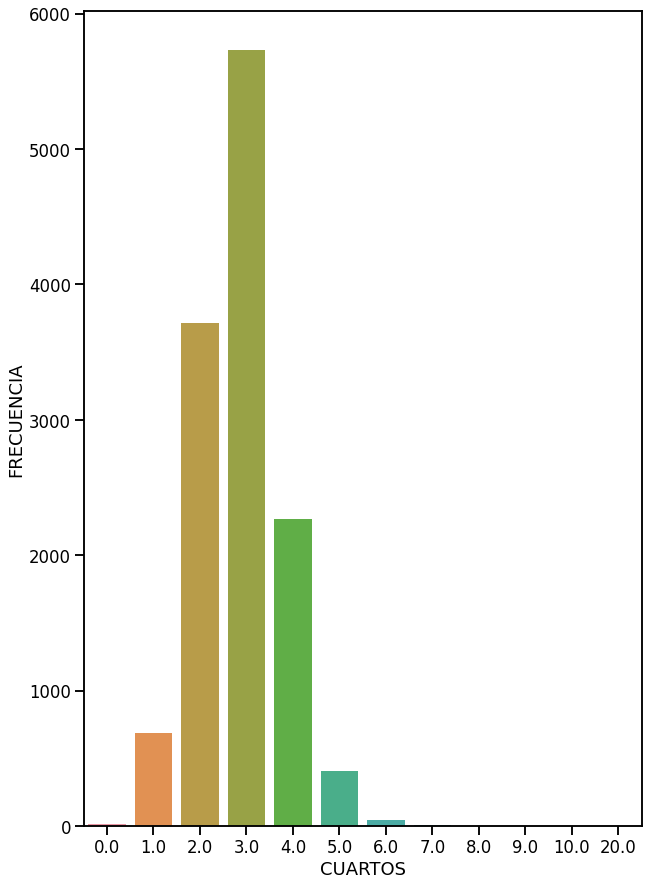

In [120]:
fig = plt.figure(figsize=(10,15))
seaborn.countplot(melb3_df.Bedroom2)
plt.xticks(rotation=0)
plt.xlabel("CUARTOS")
plt.ylabel("FRECUENCIA")
plt.show()

In [121]:
Bedroom2 = melb3_df.Bedroom2
Rooms = melb3_df.Rooms
pd.crosstab(Bedroom2,Rooms)

Rooms,1,2,3,4,5,6,7,8,10
Bedroom2,,,,,,,,,
0.00,0,5,8,2,0,0,0,0,0
1.00,662,20,5,2,0,0,0,0,0
2.00,16,3524,160,18,1,0,0,0,0
3.00,2,73,5485,159,13,1,0,0,0
4.00,0,8,65,2167,27,4,0,1,0
5.00,0,1,5,12,386,1,1,0,0
6.00,0,0,0,0,0,48,0,2,0
7.00,0,0,0,0,1,1,6,0,0
8.00,0,0,0,0,1,0,0,4,0


In [122]:
melb4_df=melb3_df.drop(['Bedroom2'], axis=1)

In [123]:
melb5_df=melb4_df.copy()

**Bathroom**: Esta variable contiene varios registros que toman el valor 0, lo cual pareceria ser un error, ya que estamos analizando el precio de propiedades construidas, no de terrenos, por lo tanto todas deberian tener al menos 1 baño. 
Para resolver este problema se decide que aquellos registros que tienen 0 baños, se le otroga el valor de 1.

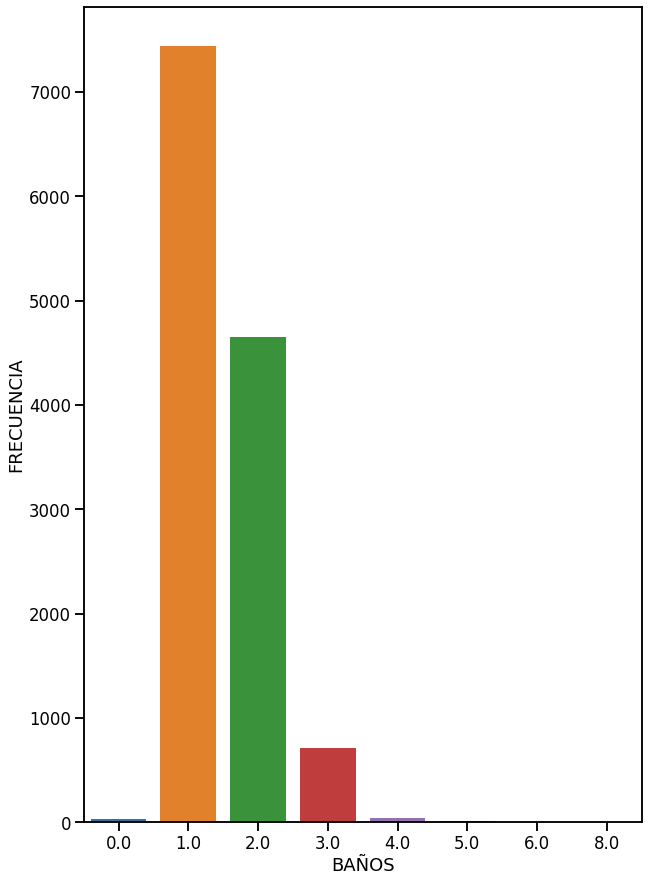

In [124]:
fig = plt.figure(figsize=(10,15))
seaborn.countplot(melb5_df.Bathroom)
plt.xticks(rotation=0)
plt.xlabel("BAÑOS")
plt.ylabel("FRECUENCIA")
plt.show()

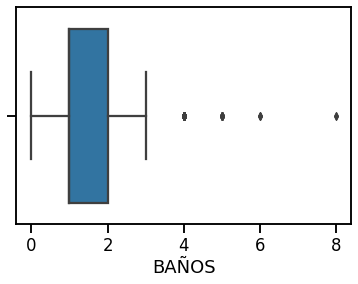

In [125]:
seaborn.boxplot(x=melb5_df["Bathroom"])
plt.xlabel("BAÑOS")
plt.show()

In [126]:
Bathroom = melb5_df.Bathroom
Rooms = melb5_df.Rooms
pd.crosstab(Bathroom,Rooms)

Rooms,1,2,3,4,5,6,7,8,10
Bathroom,,,,,,,,,
0.00,1,19,11,3,0,0,0,0,0
1.00,674,3106,3217,430,15,2,0,0,0
2.00,5,498,2361,1548,219,18,2,2,0
3.00,0,8,135,359,173,29,4,2,1
4.00,0,0,3,18,11,6,1,2,0
5.00,0,0,1,2,10,0,0,0,0
6.00,0,0,2,0,1,0,0,0,0
8.00,0,0,0,1,0,0,0,1,0


In [127]:
melb5_df.loc[melb5_df.Bathroom<1,'Bathroom']=1

In [128]:
cols = melb5_df[melb5_df == 0].count(axis=0)
cols[cols > 0]

Distance           6
Car              997
Landsize        1924
BuildingArea      13
dtype: int64

In [129]:
melb6_df=melb5_df.copy()

**Car:** esta variable presenta 997 valores iguales a 0, pero esto puede ser simplemente debido a que la propiedad no tenga cochera.
Sus datos faltantes son pocos, y los imputamos como 0.

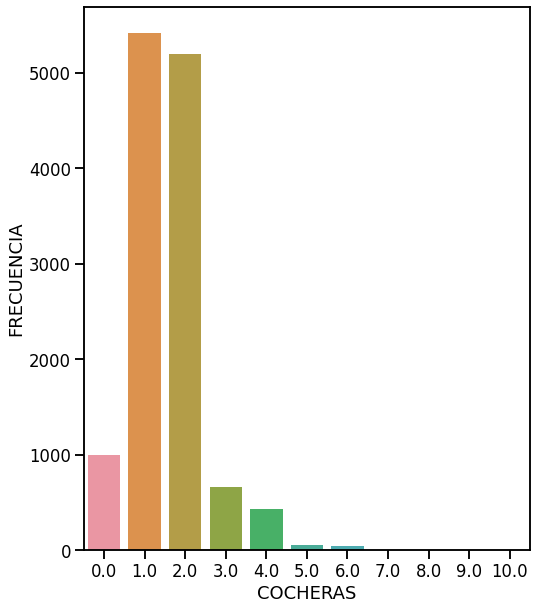

In [130]:
fig = plt.figure(figsize=(8,10))
seaborn.countplot(melb6_df.Car)
plt.xticks(rotation=0)
plt.xlabel("COCHERAS")
plt.ylabel("FRECUENCIA")
plt.show()

In [131]:
melb6_df[["Car"]]=melb6_df[["Car"]].fillna(0.0)

In [132]:
melb7_df=melb6_df.copy()

In [133]:
melb7_df.shape

(12901, 20)

**Landsize:** esta variable contiene la mayoria de los valores antes de los 10.000, los mas grandes parecerian ser erroneos, por lo tanto se decide recortar hasta ese valor, haciendo esto se pierden 25 datos. A su vez, hay 1924 que tienen valor 0, lo que no tendria sentido ya que se trata del tamaño del terreno, por lo tanto a esos valores se les decide asignar el valor de la media.

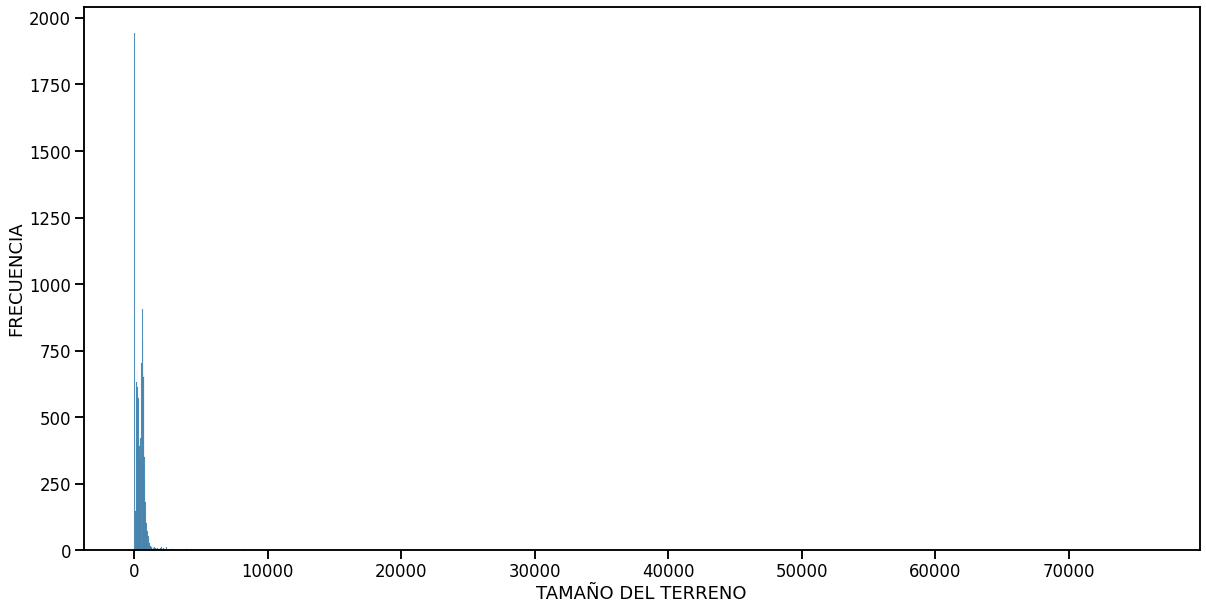

In [134]:
fig = plt.figure(figsize=(20,10))
seaborn.histplot(x=melb7_df["Landsize"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("TAMAÑO DEL TERRENO")
plt.ylabel("FRECUENCIA")
plt.show()

In [135]:
melb8_df= melb7_df[((melb7_df['Landsize']<(10000)))]

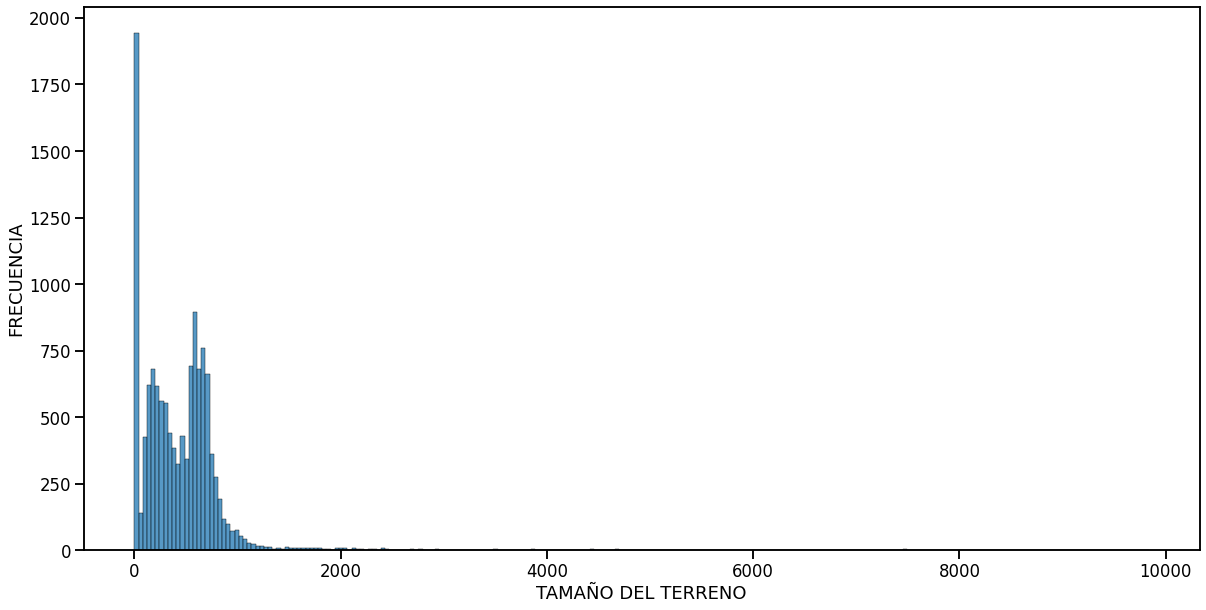

In [136]:
fig = plt.figure(figsize=(20,10))
seaborn.histplot(x=melb8_df["Landsize"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("TAMAÑO DEL TERRENO")
plt.ylabel("FRECUENCIA")
plt.show()

In [137]:
avg_Landsize=melb8_df["Landsize"].mean()
print (avg_Landsize)

465.6621621621622


In [138]:
melb9_df=melb8_df.copy()

In [139]:
melb9_df.loc[melb8_df.Landsize<1,'Landsize']=avg_Landsize

In [140]:
cols2 = melb9_df[melb9_df == 0].count(axis=0)
cols2[cols2 > 0]

Distance           6
Car             1055
BuildingArea      13
dtype: int64

**BuildingArea:** esta variable tiene 13 valores iguales a 0, lo que pareceria ser un error ya que se trata de propiedades no de terrenos, a esos valores se les asigna el valor de la media. La mayoria de sus valores se encuentran acumulados antes de los 1000 m2, por lo tanto se decide recortar hasta ese valor.


In [141]:
melb10_df=melb9_df.copy()

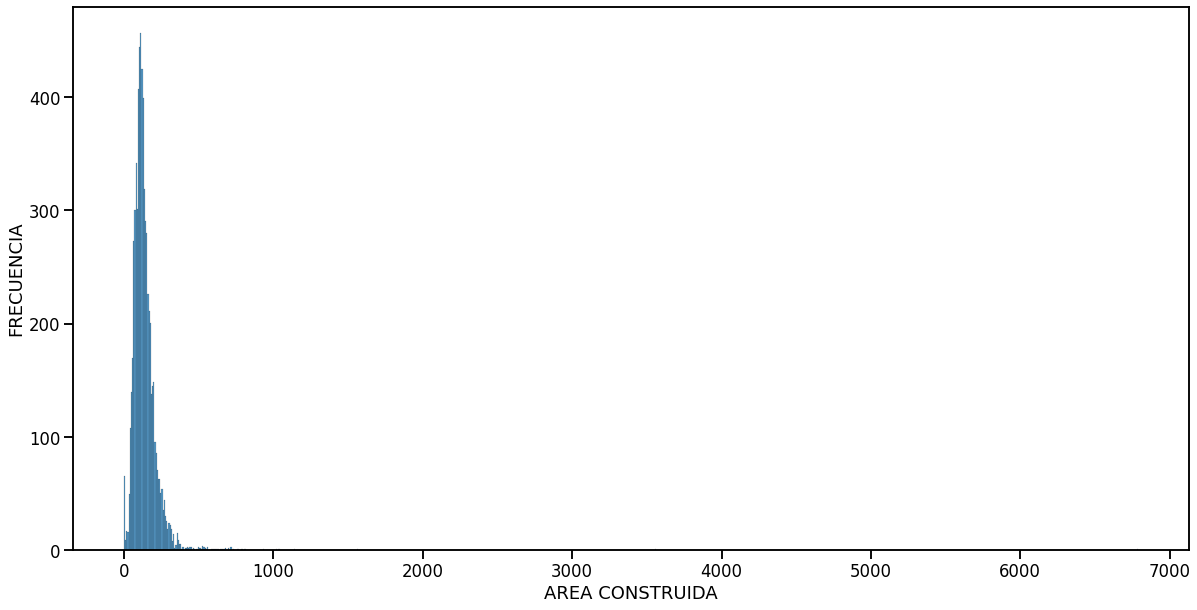

In [142]:
fig = plt.figure(figsize=(20,10))
seaborn.histplot(x=melb10_df["BuildingArea"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("AREA CONSTRUIDA")
plt.ylabel("FRECUENCIA")
plt.show()

In [143]:
melb11_df= melb10_df[((melb10_df['BuildingArea']<(1000))) | (melb10_df.BuildingArea.isnull())]

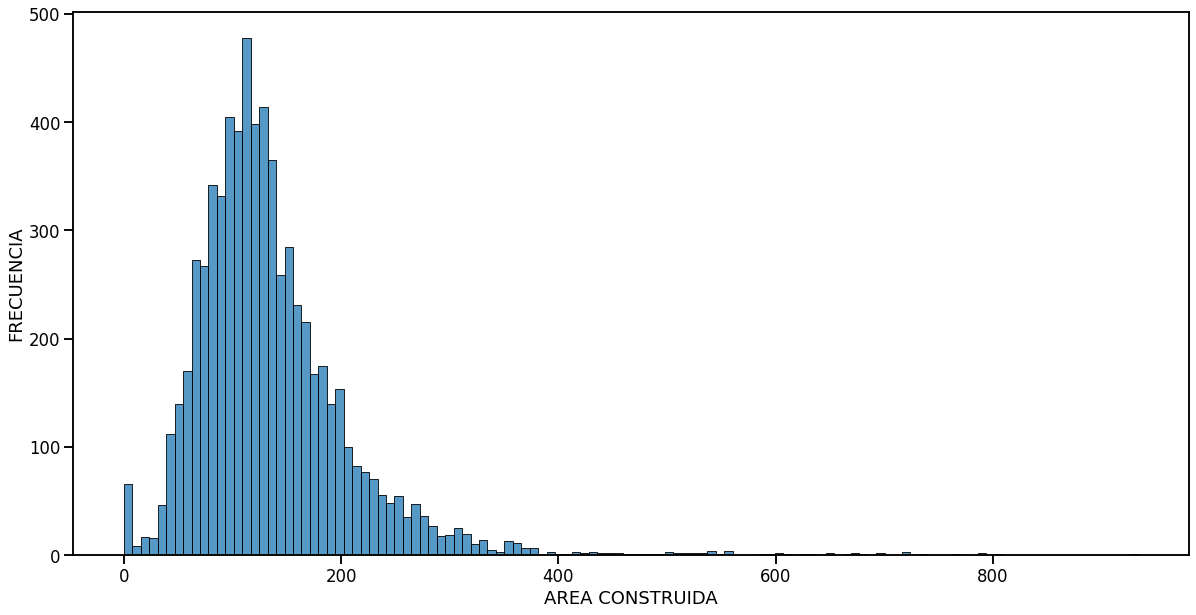

In [144]:
fig = plt.figure(figsize=(20,10))
seaborn.histplot(x=melb11_df["BuildingArea"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("AREA CONSTRUIDA")
plt.ylabel("FRECUENCIA")
plt.show()

In [145]:
avg_BuildingArea=melb11_df["BuildingArea"].mean()
print (avg_BuildingArea)

136.02892795714925


In [146]:
melb12_df=melb11_df.copy()

In [147]:
melb12_df.loc[melb11_df.BuildingArea<1,'BuildingArea']=avg_BuildingArea

In [148]:
cols3 = melb12_df[melb12_df == 0].count(axis=0)
cols3[cols3 > 0]

Distance       6
Car         1054
dtype: int64

**YearBuilt:** el minimo valor de esta variable es 1196, por lo tanto se decide recortar desde 1900.

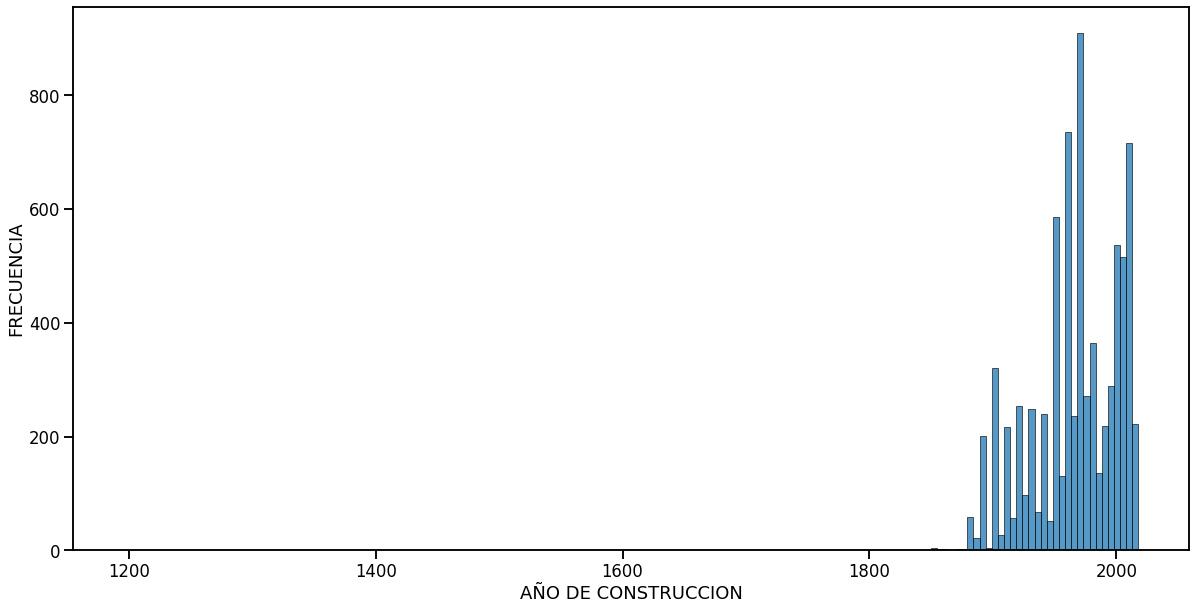

In [149]:
fig = plt.figure(figsize=(20,10))
seaborn.histplot(x=melb12_df["YearBuilt"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("AÑO DE CONSTRUCCION")
plt.ylabel("FRECUENCIA")
plt.show()

In [150]:
melb13_df= melb12_df[((melb12_df['YearBuilt']>(1900))) | (melb12_df.YearBuilt.isnull())]

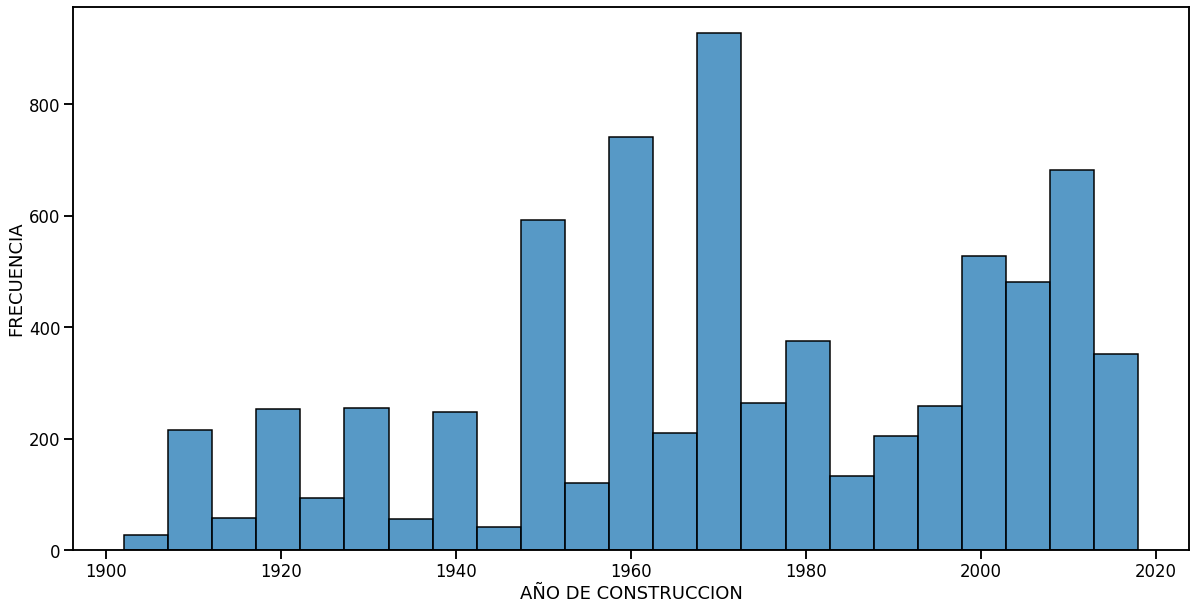

In [151]:
fig = plt.figure(figsize=(20,10))
seaborn.histplot(x=melb13_df["YearBuilt"])
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel("AÑO DE CONSTRUCCION")
plt.ylabel("FRECUENCIA")
plt.show()

In [152]:
melb13_df["YearBuilt"].isna().sum()

5124

Luego de haber realizado un analisis exploratorio de las variables pasamos a la seleccion de las columnas relevantes a la hora de predecir el valor de la propiedad. 

Para esto se muestra la correlacion entre las distintas variables, para ver que tan fuerte es la relacion entre cada una de estas con el precio.

La correlación toma valores entre -1 y 1:

-1: Correlacion negativa exacta implica que si el valor de una variable está presente, en la otra esta ausente.

0: Falta de correlacion implica que no se peude ver una relación lineal.

1: Correlacion positva exacta implica que si una variable tiene valor, en la otra definitivamente va a tomar valor tambien.

In [153]:
melb13_df.corr()

,Rooms,Price,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
Rooms,1.00,0.49,0.34,0.04,0.57,0.40,0.04,0.61,-0.07,0.04,0.08,-0.09
Price,0.49,1.00,-0.12,0.08,0.39,0.23,0.01,0.51,-0.31,-0.22,0.24,-0.07
Distance,0.34,-0.12,1.00,0.45,0.16,0.27,0.06,0.24,0.12,-0.15,0.25,-0.05
Postcode,0.04,0.08,0.45,1.00,0.10,0.04,0.05,0.08,0.04,-0.40,0.45,0.06
Bathroom,0.57,0.39,0.16,0.10,1.00,0.30,0.03,0.52,0.22,-0.05,0.11,-0.06
Car,0.40,0.23,0.27,0.04,0.30,1.00,0.09,0.34,0.03,0.01,0.05,-0.03
Landsize,0.04,0.01,0.06,0.05,0.03,0.09,1.00,0.03,0.02,-0.02,0.06,0.00
BuildingArea,0.61,0.51,0.24,0.08,0.52,0.34,0.03,1.00,0.04,-0.02,0.10,-0.08
YearBuilt,-0.07,-0.31,0.12,0.04,0.22,0.03,0.02,0.04,1.00,0.05,-0.04,0.01
Lattitude,0.04,-0.22,-0.15,-0.40,-0.05,0.01,-0.02,-0.02,0.05,1.00,-0.36,0.05


Las variables numericas mas relacionadas con el precio son "BuildingArea", "Bathroom" y "Rooms", ya que toman valores de correlacion cercanos a 0.4.

A su vez la variable "YearBuilt" toma un valor relativamente alto aunque negativo.
Las variables **Longtitude, Lattitude, Propertycount y Distance** se descartan porque se considera el barrio, además en el caso de las dos ultimas tienen una correlacion baja con el precio.

**Date** se descarta porque se considera un mercado inmobiliario con valores estables, por lo tanto en una primera aproximacion se considera que los precios se mantienen a lo largo del tiempo, en un analisis mas profundo si deberia incluirse.

In [154]:
melb14_df=melb13_df.copy()

In [155]:
melb14_df=melb13_df.drop(['Longtitude',"Lattitude","Propertycount","Distance","Date"], axis=1)

In [156]:
melb14_df.sample(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname
5503,Seddon,5 Williamstown Rd,2,h,822500.00,SP,Biggin,3011.00,2.00,1.00,228.00,111.00,1930.00,Maribyrnong,Western Metropolitan
905,Bentleigh East,1 Jassa St,3,h,1352000.00,S,Woodards,3165.00,1.00,2.00,686.00,122.00,1950.00,Glen Eira,Southern Metropolitan
8430,Sunshine West,13 Murray St,3,h,700000.00,PI,Douglas,3020.00,1.00,2.00,701.00,NaN,NaN,Brimbank,Western Metropolitan
12531,Hurstbridge,3 Milton Wy,3,h,600000.00,S,Mason,3099.00,2.00,0.00,785.00,NaN,NaN,NaN,Northern Victoria
11683,Glen Waverley,2/51 Avonhurst Dr,2,u,656000.00,S,Harcourts,3150.00,1.00,1.00,345.00,120.00,2012.00,Monash,Eastern Metropolitan


In [157]:
melb14_df.shape

(12253, 15)

Como variables categoricas se tiene: 'Suburb', 'Address', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname'.

**Address**,**CouncilArea** se descartan porque aportarian informacion muy especifica en caso de Address o que ya se ofrecida por "Suburb" y "Regionname", las cuales decidimos dejar como parte del DF.

**Method** la descartamos porque consideramos que el proceso de venta no altera el valor.

**SellerG** la descartamos porque no consideramos que el agente que venda la propiedad sea determinante para el precio.

**Type**  la consideramos porque nos parece fundamental para calcular el Precio, el tipo de casa va a variar el precio.

**Suburb** y **Regionname** son utiles para determinar la ubicacion geografica y el valor asociado a ella.

In [158]:
melb15_df=melb14_df.copy()

In [159]:
melb15_df=melb14_df.drop(['Address',"Method","SellerG","CouncilArea"], axis=1)

In [160]:
melb15_df[:]

,Suburb,Rooms,Type,Price,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname
0,Abbotsford,2,h,1480000.00,3067.00,1.00,1.00,202.00,NaN,NaN,Northern Metropolitan
3,Abbotsford,3,h,850000.00,3067.00,2.00,1.00,94.00,NaN,NaN,Northern Metropolitan
4,Abbotsford,4,h,1600000.00,3067.00,1.00,2.00,120.00,142.00,2014.00,Northern Metropolitan
5,Abbotsford,2,h,941000.00,3067.00,1.00,0.00,181.00,NaN,NaN,Northern Metropolitan
6,Abbotsford,3,h,1876000.00,3067.00,2.00,0.00,245.00,210.00,1910.00,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...
13574,Westmeadows,3,h,582000.00,3049.00,2.00,2.00,256.00,NaN,NaN,Northern Metropolitan
13575,Wheelers Hill,4,h,1245000.00,3150.00,2.00,2.00,652.00,NaN,1981.00,South-Eastern Metropolitan
13576,Williamstown,3,h,1031000.00,3016.00,2.00,2.00,333.00,133.00,1995.00,Western Metropolitan
13577,Williamstown,3,h,1170000.00,3016.00,2.00,4.00,436.00,NaN,1997.00,Western Metropolitan


**Regionname:**

In [161]:
melb16_df=melb15_df.copy()

In [162]:
melb16_df_count=melb15_df["Regionname"].value_counts()
melb16_df_count[:]

Southern Metropolitan         3923
Northern Metropolitan         3540
Western Metropolitan          2798
Eastern Metropolitan          1425
South-Eastern Metropolitan     446
Eastern Victoria                51
Northern Victoria               38
Western Victoria                32
Name: Regionname, dtype: int64

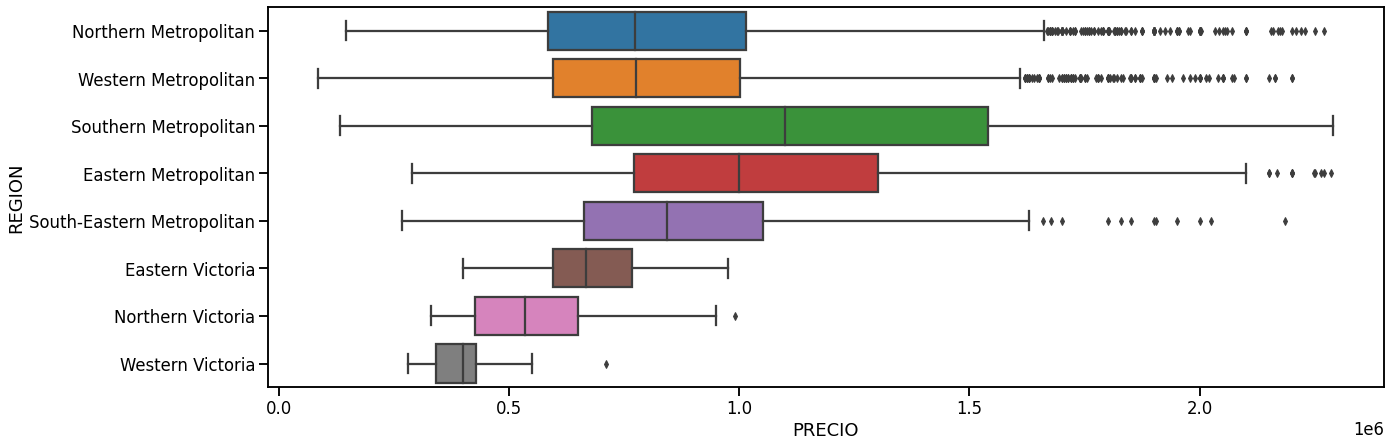

In [163]:
plt.figure(figsize=(20, 7))
seaborn.boxplot(x=melb16_df["Price"], y=melb16_df["Regionname"])
plt.xlabel("PRECIO")
plt.ylabel("REGION")
plt.show()

**Type:**

In [83]:
melb16_df_count=melb16_df["Type"].value_counts()
melb16_df_count[:]

h    8193
u    2968
t    1092
Name: Type, dtype: int64

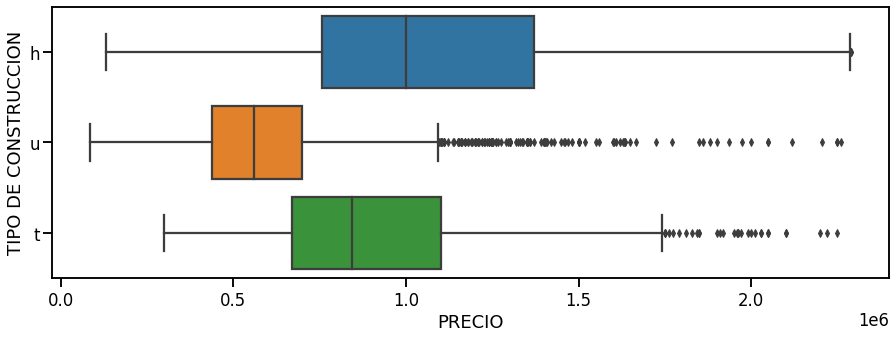

In [84]:
plt.figure(figsize=(15,5))
seaborn.boxplot(x=melb16_df["Price"], y=melb16_df["Type"])
plt.xlabel("PRECIO")
plt.ylabel("TIPO DE CONSTRUCCION")
plt.show()

Para agregar informacion adicional primero nos aseguramos de que haya una cantidad suficiente de registros como para que la informacion sea relevante.

In [164]:
intersection = numpy.intersect1d(
    airbnb_df.zipcode.values, melb16_df.Postcode.values, assume_unique=False)
print("Zipcodes Unicos de Airbnb ", len(airbnb_df.zipcode.unique()))
print("Zipcodes Unicos de Melbourne", len(melb16_df.Postcode.unique()))
print("Zipcodes comunes", len(intersection)) #para ver cuantos datos tenemos en comun

Zipcodes Unicos de Airbnb  248
Zipcodes Unicos de Melbourne 196
Zipcodes comunes 190


In [165]:
print('Records in Sales df with corresponding zipcode form Airbnb df',
      melb15_df.Postcode.isin(intersection).sum() / len(melb16_df))
print('Records in Airbnb df with corresponding zipcode form Sales df',
      airbnb_df.zipcode.isin(intersection).sum() / len(airbnb_df))

Records in Sales df with corresponding zipcode form Airbnb df 0.9986125846731413
Records in Airbnb df with corresponding zipcode form Sales df 0.9302031011137804


Utilizamos el Data set trabajado en el punto anterior

In [166]:
airbnb_price_by_zipcode.airbnb_record_count.describe()

count    247.00
mean      92.10
std      261.91
min        1.00
25%        8.50
50%       27.00
75%       73.00
max     3367.00
Name: airbnb_record_count, dtype: float64

Para sólo incluir los zipcodes que tengan una cantidad mínima de registros se decide dejar solo los que tengan una frecuencia mayor a 1. Asi se descartan 20 filas de datos.

In [167]:
airbnb_price_by_zipcode_2=airbnb_price_by_zipcode[~(airbnb_price_by_zipcode.airbnb_record_count <2)]

In [168]:
airbnb_price_by_zipcode_2

,zipcode,airbnb_price_mean,airbnb_record_count,airbnb_weekly_price_mean,airbnb_monthly_price_mean
3,3000.00,150.50,3367,918.74,3407.20
4,3001.00,132.50,2,NaN,NaN
5,3002.00,200.98,197,956.38,3712.71
6,3003.00,130.21,267,760.20,2629.50
7,3004.00,158.27,728,1061.17,3759.93
...,...,...,...,...,...
231,3975.00,99.50,6,850.00,3000.00
232,3976.00,55.00,2,NaN,NaN
233,3977.00,92.96,45,422.00,1025.00
234,3978.00,177.00,7,950.67,7770.00


Combinacion de los Dataset:

In [169]:
merged_price_df = melb16_df.merge(
    airbnb_price_by_zipcode_2, how='left',
    left_on='Postcode', right_on='zipcode'
)
merged_price_df.sample(5)

,Suburb,Rooms,Type,Price,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Regionname,zipcode,airbnb_price_mean,airbnb_record_count,airbnb_weekly_price_mean,airbnb_monthly_price_mean
5018,Southbank,2,u,430000.00,3006.00,2.00,0.00,2295.00,NaN,2014.00,Southern Metropolitan,3006.00,188.85,1268.00,1239.83,4358.56
1129,Brunswick,4,h,1350000.00,3056.00,1.00,1.00,370.00,151.00,1940.00,Northern Metropolitan,3056.00,94.67,446.00,618.76,2308.98
5161,Strathmore,4,h,1052000.00,3041.00,2.00,2.00,699.00,NaN,NaN,Western Metropolitan,3041.00,106.12,8.00,350.00,1500.00
9952,Hurstbridge,5,h,790000.00,3099.00,2.00,2.00,1034.00,225.00,1985.00,Northern Victoria,3099.00,136.00,10.00,586.25,2119.33
4490,Reservoir,2,t,380000.00,3073.00,1.00,1.00,83.00,85.00,2010.00,Northern Metropolitan,3073.00,273.93,68.00,399.89,1459.62


In [170]:
merged_price_df.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Postcode', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Regionname', 'zipcode',
       'airbnb_price_mean', 'airbnb_record_count', 'airbnb_weekly_price_mean',
       'airbnb_monthly_price_mean'],
      dtype='object')

In [171]:
merged_price_df.shape

(12253, 16)

Otras dos variables que podrian resultar utiles para combinar los datos podrian ser la Latitud y la Longitud debido a que ambas se encuentras disponibles en ambos Dataset. Otra opcion tambien podria ser uniendo Suburb de Melbourne con suburb de AirBnb.

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [172]:
merged_price_df.to_csv("merged_price_df.csv", index=None)

In [ ]:
#Para descargarlo
#from google.colab import files
#files.download("merged_price_df.csv") 

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)

In [ ]:
#Archivo trabajado en clase con promedios de precios por zipcode.
#zip_df = pd.read_csv('http://adriancontursi.com.ar/diplodatos/airbnb.csv') !!!el archivo tenia todos los precios por zipcode en lugar de solo los promedios
#from google.colab import files
#uploaded = files.upload()

In [ ]:
from sklearn.impute import SimpleImputer

#mean_imputer = SimpleImputer(strategy="mean")
#melb6_df.iloc[:,melb6_df.Landsize]=mean_imputer.fit_transform(melb6_df)

#melb6_df.loc[melb6_df.Landsize<1| (melb6_df.Landsize.isnull()),'Landsize']=avg_Landsize